In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from tqdm.notebook import tqdm

# Set random seed for reproducibility
np.random.seed(42)

def load_jet_data(data_dir='./QG_classification', max_jets=10000):
    """Load jet data from NPZ files"""
    print(f"Loading data from {data_dir}...")
    
    # Find NPZ files
    data_files = [f for f in os.listdir(data_dir) if f.endswith('.npz') and 'QG_jets_' in f]
    print(f"Found {len(data_files)} data files")
    
    # Load and combine data
    all_jets = []
    all_labels = []
    jets_loaded = 0
    
    for filename in sorted(data_files):
        if jets_loaded >= max_jets:
            break
            
        filepath = os.path.join(data_dir, filename)
        try:
            data = np.load(filepath)
            jets = data['jets'] if 'jets' in data else data['X']
            labels = data['labels'] if 'labels' in data else data['y']
            
            # Only take what we need
            jets_to_take = min(len(jets), max_jets - jets_loaded)
            
            all_jets.append(jets[:jets_to_take])
            all_labels.append(labels[:jets_to_take])
            
            jets_loaded += jets_to_take
            print(f"  Loaded {jets_to_take} jets from {filename}")
            
        except Exception as e:
            print(f"  Error loading {filepath}: {e}")
    
    # Combine data
    X = np.vstack(all_jets)
    y = np.concatenate(all_labels)
    
    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Print dataset information
    print(f"\nDataset loaded: {len(X)} jets total")
    print(f"  Quark jets: {np.sum(y == 1)} ({np.mean(y == 1)*100:.1f}%)")
    print(f"  Gluon jets: {np.sum(y == 0)} ({np.mean(y == 0)*100:.1f}%)")
    print(f"  Features per particle: {X.shape[2]}")
    print(f"  Training set: {len(X_train)} jets")
    print(f"  Test set: {len(X_test)} jets")
    
    return X_train, X_test, y_train, y_test

# Load data
X_train, X_test, y_train, y_test = load_jet_data(max_jets=10000)

# Show sample jet
print("\nSample jet (first 3 particles):")
print(X_train[0][:3])

Loading data from ./QG_classification...
Found 39 data files
  Loaded 10000 jets from QG_jets_1.npz

Dataset loaded: 10000 jets total
  Quark jets: 5053 (50.5%)
  Gluon jets: 4947 (49.5%)
  Features per particle: 4
  Training set: 8000 jets
  Test set: 2000 jets

Sample jet (first 3 particles):
[[ 5.59088114e-02  1.47941478e+00  1.70961803e+00  2.20000000e+01]
 [ 5.89929297e-02  9.83142726e-01  2.19934506e+00 -2.11000000e+02]
 [ 5.97843609e-01  9.52477044e-01  1.95767132e+00  2.11000000e+02]]


In [2]:
def prepare_graphs(jets, labels, max_particles=30):
    """Convert jet data to graph representation with basic preprocessing"""
    print(f"Converting {len(jets)} jets to graph structure...")
    graphs = []
    
    for jet, label in zip(jets, labels):
        # Filter valid particles (non-zero pt)
        valid_mask = jet[:, 0] > 0
        particles = jet[valid_mask]
        
        if len(particles) == 0:
            continue
            
        # Sort by decreasing pt
        sort_indices = np.argsort(-particles[:, 0])
        particles = particles[sort_indices]
        
        # Limit number of particles
        n_particles = min(len(particles), max_particles)
        particles = particles[:n_particles]
        
        # Store graph data
        graphs.append({
            'particles': particles,          # Particle features
            'label': label,                  # Jet label (0=gluon, 1=quark)
            'n_particles': n_particles       # Number of particles
        })
    
    print(f"Created {len(graphs)} graphs")
    
    # Stats on particle counts
    particle_counts = [g['n_particles'] for g in graphs]
    print(f"Particles per jet: min={min(particle_counts)}, " +
          f"max={max(particle_counts)}, " +
          f"avg={np.mean(particle_counts):.1f}")
    
    return graphs

# Convert jets to graphs
train_graphs = prepare_graphs(X_train, y_train)
test_graphs = prepare_graphs(X_test, y_test)

# Analyze first graph
sample_graph = train_graphs[0]
print(f"\nSample graph:")
print(f"  Number of particles: {sample_graph['n_particles']}")
print(f"  Label: {'quark' if sample_graph['label'] == 1 else 'gluon'}")
print(f"  First particle features: {sample_graph['particles'][0]}")

Converting 8000 jets to graph structure...
Created 8000 graphs
Particles per jet: min=5, max=30, avg=28.2
Converting 2000 jets to graph structure...
Created 2000 graphs
Particles per jet: min=4, max=30, avg=28.1

Sample graph:
  Number of particles: 29
  Label: quark
  First particle features: [  99.70838078    1.21366856    1.97440808 -211.        ]


Test circuit output: -0.0493


/var/folders/61/z36hrmy516l8jpg81wnm8pr00000gn/T/ipykernel_79289/844337246.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

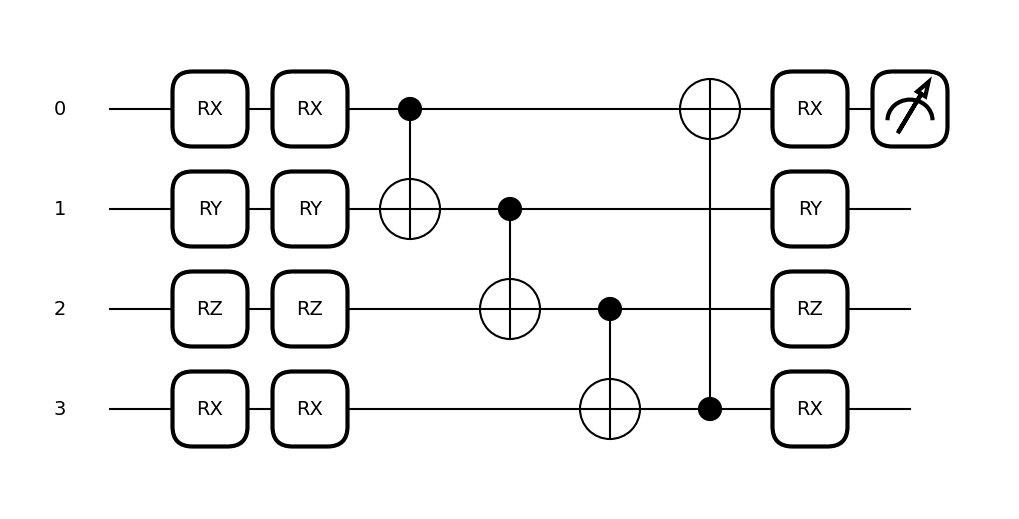

In [ ]:
def create_qubit_circuit(n_qubits=4):
    """Create a parameterized quantum circuit for processing particle features"""
    # Create quantum device
    dev = qml.device("default.qubit", wires=n_qubits)
    
    @qml.qnode(dev)
    def circuit(features, params):
        # Encode features into qubit rotations
        qml.RX(features[0], wires=0)  # pt
        qml.RY(features[1], wires=1)  # eta
        qml.RZ(features[2], wires=2)  # phi
        qml.RX(features[3], wires=3)  # energy
        
        # First parameterized rotation layer
        qml.RX(params[0], wires=0)
        qml.RY(params[1], wires=1)
        qml.RZ(params[2], wires=2)
        qml.RX(params[3], wires=3)
        
        # Entanglement layer
        qml.CNOT(wires=[0, 1])
        qml.CNOT(wires=[1, 2])
        qml.CNOT(wires=[2, 3])
        qml.CNOT(wires=[3, 0])
        
        # Second parameterized rotation layer
        qml.RX(params[4], wires=0)
        qml.RY(params[5], wires=1)
        qml.RZ(params[6], wires=2)
        qml.RX(params[7], wires=3)
        
        # Return measurement expectation
        return qml.expval(qml.PauliZ(0))
    
    return circuit

def normalize_features(features):
    """Normalize particle features to [0, π] for quantum circuit input"""
    # PT: scale to [0, π]
    pt_norm = np.clip(features[0] / 100.0, 0, 1) * np.pi
    
    # ETA: scale from [-5, 5] to [0, π]
    eta_norm = (np.clip(features[1], -5, 5) + 5) / 10.0 * np.pi
    
    # PHI: scale from [-π, π] to [0, π]
    phi_norm = (np.clip(features[2], -np.pi, np.pi) + np.pi) / (2 * np.pi) * np.pi
    
    # Energy: scale to [0, π]
    energy_norm = np.clip(features[3] / 200.0, 0, 1) * np.pi
    
    return np.array([pt_norm, eta_norm, phi_norm, energy_norm])

# Create and test a quantum circuit
circuit = create_qubit_circuit()
test_features = normalize_features(train_graphs[0]['particles'][0])
test_params = np.random.uniform(0, np.pi, 8)
test_result = circuit(test_features, test_params)
print(f"Test circuit output: {test_result:.4f}")

# Draw the circuit
plt.figure(figsize=(10, 6))
@qml.qnode(qml.device("default.qubit", wires=4))
def draw_circuit():
    # Just for visualization - with fixed values
    qml.RX(0.5, wires=0)
    qml.RY(0.8, wires=1)
    qml.RZ(1.0, wires=2)
    qml.RX(1.2, wires=3)
    
    qml.RX(0.1, wires=0)
    qml.RY(0.2, wires=1)
    qml.RZ(0.3, wires=2)
    qml.RX(0.4, wires=3)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])
    
    qml.RX(0.5, wires=0)
    qml.RY(0.6, wires=1)
    qml.RZ(0.7, wires=2)
    qml.RX(0.8, wires=3)
    
    return qml.expval(qml.PauliZ(0))

fig, ax = qml.draw_mpl(draw_circuit)()
plt.tight_layout()
plt.show()

In [4]:
class QGNN:
    def __init__(self, n_particles=5):
        """
        Quantum Graph Neural Network for jet classification
        
        Args:
            n_particles: Number of highest-pt particles to use
        """
        self.n_particles = n_particles
        self.circuit = create_qubit_circuit()
        
        # Initialize parameters with small values
        self.params = np.random.uniform(0, 0.1, 8)
        print(f"Initial parameters: {self.params}")
    
    def process_graph(self, graph, params=None):
        """Process a graph with the current model parameters"""
        if params is None:
            params = self.params
            
        # Get particles (already sorted by pt)
        particles = graph['particles']
        n_particles = min(len(particles), self.n_particles)
        
        # Process each particle through the quantum circuit
        particle_outputs = []
        
        for i in range(n_particles):
            # Normalize features
            norm_features = normalize_features(particles[i])
            
            # Run quantum circuit
            output = self.circuit(norm_features, params)
            particle_outputs.append(output)
        
        # If we have fewer particles than expected, pad with zeros
        if n_particles < self.n_particles:
            particle_outputs.extend([0] * (self.n_particles - n_particles))
        
        # Combine particle outputs with exponentially decaying weights
        # (higher weight for leading particles)
        weights = np.exp(-np.arange(self.n_particles) * 0.5)
        weights = weights / np.sum(weights)
        
        combined_output = np.sum(np.array(particle_outputs) * weights)
        
        # Map output from [-1,1] to [0,1] for binary classification
        probability = (1 - combined_output) / 2
        
        return probability
    
    def predict(self, graph):
        """Predict class label (0=gluon, 1=quark)"""
        prob = self.process_graph(graph)
        return 1 if prob > 0.5 else 0
    
    def calculate_loss(self, graph, label):
        """Calculate binary cross-entropy loss"""
        prob = self.process_graph(graph)
        # Clip for numerical stability
        prob = np.clip(prob, 1e-10, 1-1e-10)
        return -1 * (label * np.log(prob) + (1-label) * np.log(1-prob))
    
    def calculate_gradient(self, graph, label, epsilon=0.01):
        """Calculate gradient for parameters using symmetric finite differences"""
        gradients = np.zeros(8)
        
        # Calculate base loss
        base_loss = self.calculate_loss(graph, label)
        
        # Calculate gradient for each parameter
        for i in range(8):
            # Parameters with positive perturbation
            params_plus = self.params.copy()
            params_plus[i] += epsilon
            
            # Parameters with negative perturbation
            params_minus = self.params.copy()
            params_minus[i] -= epsilon
            
            # Calculate losses with perturbed parameters
            prob_plus = self.process_graph(graph, params_plus)
            prob_plus = np.clip(prob_plus, 1e-10, 1-1e-10)
            loss_plus = -1 * (label * np.log(prob_plus) + (1-label) * np.log(1-prob_plus))
            
            prob_minus = self.process_graph(graph, params_minus)
            prob_minus = np.clip(prob_minus, 1e-10, 1-1e-10)
            loss_minus = -1 * (label * np.log(prob_minus) + (1-label) * np.log(1-prob_minus))
            
            # Symmetric gradient
            gradients[i] = (loss_plus - loss_minus) / (2 * epsilon)
        
        return gradients, base_loss
    
    def train(self, train_graphs, test_graphs, n_steps=100, batch_size=10, learning_rate=0.1):
        """Train the model using gradient descent with momentum"""
        # Training history
        history = {
            'train_loss': [],
            'test_accuracy': [],
            'parameters': []
        }
        
        # Create balanced dataset indices
        quark_indices = [i for i, g in enumerate(train_graphs) if g['label'] == 1]
        gluon_indices = [i for i, g in enumerate(train_graphs) if g['label'] == 0]
        
        print(f"Training set: {len(quark_indices)} quarks, {len(gluon_indices)} gluons")
        
        # Momentum optimization
        velocity = np.zeros(8)
        momentum = 0.9
        
        # Training loop
        for step in range(n_steps):
            # Adaptive learning rate
            lr = learning_rate * (1.0 - step/n_steps)
            
            # Create balanced mini-batch
            batch_quark = np.random.choice(quark_indices, batch_size//2, replace=False)
            batch_gluon = np.random.choice(gluon_indices, batch_size//2, replace=False)
            batch_indices = np.concatenate([batch_quark, batch_gluon])
            np.random.shuffle(batch_indices)
            
            batch_graphs = [train_graphs[i] for i in batch_indices]
            
            # Calculate gradients on batch
            batch_gradients = np.zeros(8)
            batch_loss = 0
            
            for graph in batch_graphs:
                grad, loss = self.calculate_gradient(graph, graph['label'])
                batch_gradients += grad
                batch_loss += loss
            
            # Average gradients and loss
            batch_gradients /= batch_size
            batch_loss /= batch_size
            
            # Gradient clipping
            grad_norm = np.linalg.norm(batch_gradients)
            if grad_norm > 1.0:
                batch_gradients = batch_gradients / grad_norm
            
            # Update with momentum
            velocity = momentum * velocity - lr * batch_gradients
            self.params += velocity
            
            # Record history
            history['train_loss'].append(batch_loss)
            history['parameters'].append(self.params.copy())
            
            # Evaluate on test set (every 10 steps)
            if step % 10 == 0 or step == n_steps - 1:
                # Sample balanced test subset
                test_quark = [i for i, g in enumerate(test_graphs) if g['label'] == 1]
                test_gluon = [i for i, g in enumerate(test_graphs) if g['label'] == 0]
                
                test_size = min(50, min(len(test_quark), len(test_gluon)) * 2)
                test_indices = np.concatenate([
                    np.random.choice(test_quark, test_size//2, replace=False),
                    np.random.choice(test_gluon, test_size//2, replace=False)
                ])
                
                test_subset = [test_graphs[i] for i in test_indices]
                
                # Evaluate
                predictions = [self.predict(g) for g in test_subset]
                true_labels = [g['label'] for g in test_subset]
                accuracy = accuracy_score(true_labels, predictions)
                
                history['test_accuracy'].append(accuracy)
                
                print(f"Step {step}: Loss = {batch_loss:.4f}, Accuracy = {accuracy:.4f}, LR = {lr:.4f}")
            else:
                print(f"Step {step}: Loss = {batch_loss:.4f}")
        
        return history

# Create model and test
model = QGNN(n_particles=5)
test_prob = model.process_graph(train_graphs[0])
print(f"Initial prediction: {test_prob:.4f} (true: {train_graphs[0]['label']})")

Initial parameters: [0.09699099 0.08324426 0.02123391 0.0181825  0.01834045 0.03042422
 0.05247564 0.0431945 ]
Initial prediction: 0.6103 (true: 1.0)


Training QGNN model...
Training set: 4042 quarks, 3958 gluons
Step 0: Loss = 0.6964, Accuracy = 0.4600, LR = 0.1000
Step 1: Loss = 0.6853
Step 2: Loss = 0.6571
Step 3: Loss = 0.6763
Step 4: Loss = 0.7613
Step 5: Loss = 0.6395
Step 6: Loss = 0.6952
Step 7: Loss = 0.6947
Step 8: Loss = 0.6610
Step 9: Loss = 0.7012
Step 10: Loss = 0.7028, Accuracy = 0.4800, LR = 0.0500
Step 11: Loss = 0.7101
Step 12: Loss = 0.6885
Step 13: Loss = 0.6689
Step 14: Loss = 0.6635
Step 15: Loss = 0.6648
Step 16: Loss = 0.6532
Step 17: Loss = 0.7061
Step 18: Loss = 0.7074
Step 19: Loss = 0.7430, Accuracy = 0.5200, LR = 0.0050

Training complete!
Final parameters: [ 0.09699099 -0.5334296   0.02123391  1.61798322  0.40488481  0.03042422
  0.05247564  0.0431945 ]
Final loss: 0.7430
Final accuracy: 0.5200


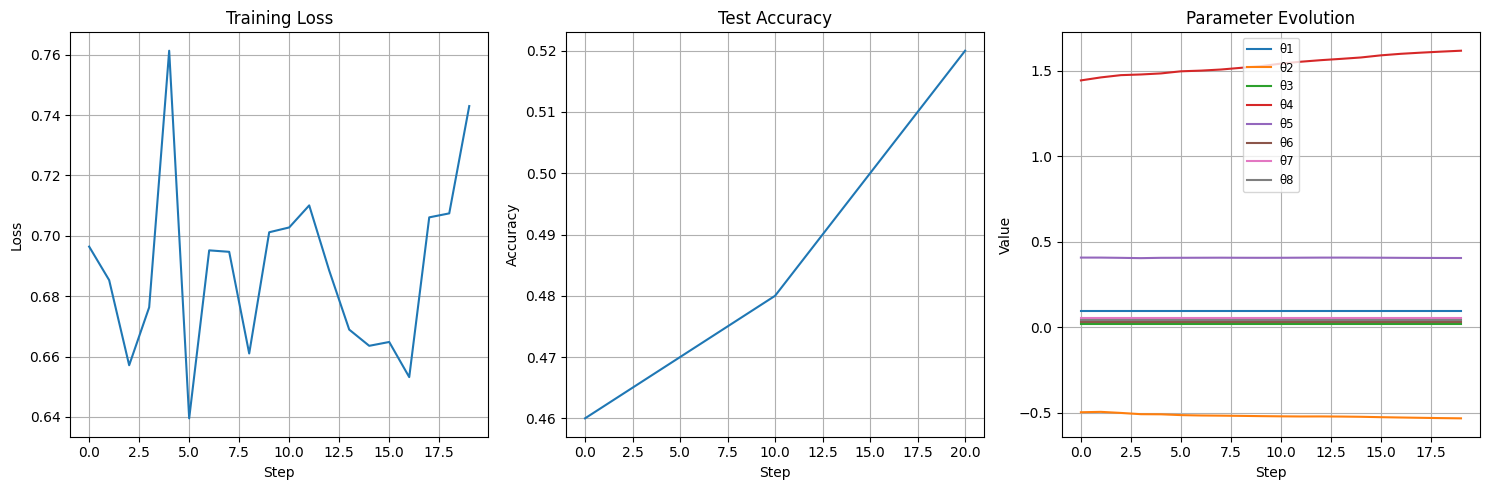

In [14]:
# Train the model
print("Training QGNN model...")
history = model.train(
    train_graphs,
    test_graphs,
    n_steps=20,
    batch_size=10,
    learning_rate=0.1
)

# Print final parameters
print("\nTraining complete!")
print(f"Final parameters: {model.params}")
print(f"Final loss: {history['train_loss'][-1]:.4f}")
print(f"Final accuracy: {history['test_accuracy'][-1]:.4f}")

# Plot training progress
plt.figure(figsize=(15, 5))

# Plot loss
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'])
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid(True)

# Plot test accuracy
plt.subplot(1, 3, 2)
steps = range(0, len(history['test_accuracy'])*10, 10)
plt.plot(steps, history['test_accuracy'])
plt.title('Test Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.grid(True)

# Plot parameter evolution
plt.subplot(1, 3, 3)
params_array = np.array(history['parameters'])
for i in range(8):
    plt.plot(params_array[:, i], label=f'θ{i+1}')
plt.title('Parameter Evolution')
plt.xlabel('Step')
plt.ylabel('Value')
plt.legend(fontsize='small')
plt.grid(True)

plt.tight_layout()
plt.show()

The test accuracy stabily rises with the process of training, however, the model was not working much better than pure random so I guess my quantum circuit and training method design has problems to be solved. 